In [1]:
import torch
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla P100-PCIE-16GB


In [2]:
import torch.nn as nn

In [3]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

In [4]:
class UnFlatten(nn.Module):
  def forward(self, input, size=1024):
    return input.view(input.size(0), size, 1, 1)

In [5]:
class VAE(nn.Module):
  def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=2, stride=2),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=2, stride=2),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=2, stride=2),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=2, stride=2),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(256, 512, kernel_size=2, stride=2),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(512, 1024, kernel_size=2, stride=2),
      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(1024, 1024, kernel_size=2, stride=2),
      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      Flatten()
    )
    self.fc1 = nn.Linear(h_dim, z_dim)
    self.fc2 = nn.Linear(h_dim, z_dim)
    self.fc3 = nn.Linear(z_dim, h_dim) 
    self.decoder = nn.Sequential(
      UnFlatten(),
      nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2),
      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
      nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Sigmoid(),
    )
      
  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    # return torch.normal(mu, std)
    esp = torch.randn(*mu.size())
    z = mu+std*esp.to(device)
    return z

  def bottleneck(self, h):
    mu, logvar = self.fc1(h), self.fc2(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self, x):
    h=self.encoder(x)
    z,mu,logvar=self.bottleneck(h)
    return z, mu, logvar

  def decode(self, z):
    z = self.fc3(z)
    z = self.decoder(z)
    return z

  def forward(self, x):
    z, mu, logvar = self.encode(x)
    z = self.decode(z)
    return z, mu, logvar

In [6]:
model=VAE()
model.to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_run

In [7]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             416
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           8,256
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          32,896
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         131,328
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]         524,800
      BatchNorm2d-14            [-1, 51

In [8]:
import torch.nn.functional as F

In [9]:
def loss_fn(recon_x, x, mu, logvar):
  #BCE = F.binary_cross_entropy(recon_x, x, size_average=False).to(device)
  MSE = F.mse_loss(recon_x, x, reduction='sum')
  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp()).to(device)
  return MSE+KLD, MSE, KLD

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#Connect to Google drive

In [11]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [12]:
from torchvision import transforms
transformer = transforms.Compose([
  transforms.Resize((128, 128)),       
  transforms.ToTensor(),                     
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

In [13]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(root = "/content/gdrive/MyDrive/Image folders/train", transform = transformer)

In [14]:
import torch.utils.data as Data
loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True)

#Try to send one batch of training images to NN

In [15]:
for batchX, _ in loader:
  break;
print(batchX.shape)

torch.Size([16, 3, 128, 128])


### encoder

In [16]:
h = model.encoder(batchX.to(device))
print(h.shape)

torch.Size([16, 1024])


In [17]:
mu=model.fc1(h)
print(mu.shape)

torch.Size([16, 64])


In [18]:
logvar=model.fc2(h)
print(logvar.shape)

torch.Size([16, 64])


In [19]:
std = logvar.mul(0.5).exp_()
print(std.shape)

torch.Size([16, 64])


In [20]:
esp=torch.randn(*mu.size())
print(esp.shape)

torch.Size([16, 64])


In [21]:
z=mu+std*esp.to(device)
print(z.shape)

torch.Size([16, 64])


### decode

In [22]:
z=model.decode(z)

### encoder+decoder together

In [23]:
tensorY,mu,logvar = model(batchX.to(device))
print(tensorY.shape)

torch.Size([16, 3, 128, 128])


In [24]:
loss, mse,kld = loss_fn(tensorY, batchX.to(device), mu, logvar)
print(loss)

tensor(627375.3750, device='cuda:0', grad_fn=<AddBackward0>)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [26]:
def ConvertTensorToArray (tensorInput):
  imgTensor = torchvision.utils.make_grid(tensorInput)
  imgArray = imgTensor.numpy() 
  imgArray1 = np.zeros((imgArray.shape[1], imgArray.shape[2], 3))
  imgArray1[:,:,0] = imgArray[0, :, :]  
  imgArray1[:,:,1] = imgArray[1, :, :]
  imgArray1[:,:,2] = imgArray[2, :, :]
  imgArray1 = imgArray1*0.5+0.5
  return imgArray1

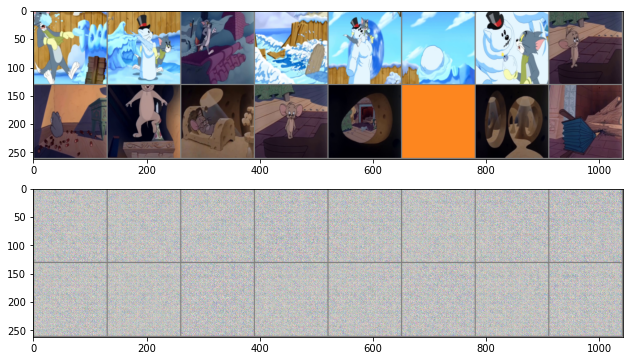

In [27]:
#compare Input vs Output
fig,axs=plt.subplots(2,1,figsize=(12,6))
imgArray=ConvertTensorToArray(batchX) 
axs[0].imshow(imgArray)
imgArray=ConvertTensorToArray(tensorY.cpu()) 
axs[1].imshow(imgArray)
plt.show()

#Training loop

In [37]:
model.train()
print("")

In [38]:
lossLst = []
for epoch in range(400):
  if(epoch%5==0):
    print("\nepoch = ", epoch, end = ", ")
    print("batch: ", end="")
  for step, (batchX, _) in enumerate(loader):
    if(epoch%5==0 and step%5==0):
      print(step, end = ",")
    tensorY,mu,logvar = model(batchX.to(device))
    loss, mse,kld = loss_fn(tensorY, batchX.to(device), mu, logvar)
    lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch =  0, batch: 0,5,10,
epoch =  5, batch: 0,5,10,
epoch =  10, batch: 0,5,10,
epoch =  15, batch: 0,5,10,
epoch =  20, batch: 0,5,10,
epoch =  25, batch: 0,5,10,
epoch =  30, batch: 0,5,10,
epoch =  35, batch: 0,5,10,
epoch =  40, batch: 0,5,10,
epoch =  45, batch: 0,5,10,
epoch =  50, batch: 0,5,10,
epoch =  55, batch: 0,5,10,
epoch =  60, batch: 0,5,10,
epoch =  65, batch: 0,5,10,
epoch =  70, batch: 0,5,10,
epoch =  75, batch: 0,5,10,
epoch =  80, batch: 0,5,10,
epoch =  85, batch: 0,5,10,
epoch =  90, batch: 0,5,10,
epoch =  95, batch: 0,5,10,
epoch =  100, batch: 0,5,10,
epoch =  105, batch: 0,5,10,
epoch =  110, batch: 0,5,10,
epoch =  115, batch: 0,5,10,
epoch =  120, batch: 0,5,10,
epoch =  125, batch: 0,5,10,
epoch =  130, batch: 0,5,10,
epoch =  135, batch: 0,5,10,
epoch =  140, batch: 0,5,10,
epoch =  145, batch: 0,5,10,
epoch =  150, batch: 0,5,10,
epoch =  155, batch: 0,5,10,
epoch =  160, batch: 0,5,10,
epoch =  165, batch: 0,5,10,
epoch =  170, batch: 0,5,10,
epoch 

In [39]:
torch.save(model.state_dict(),"VAE800.pkl")

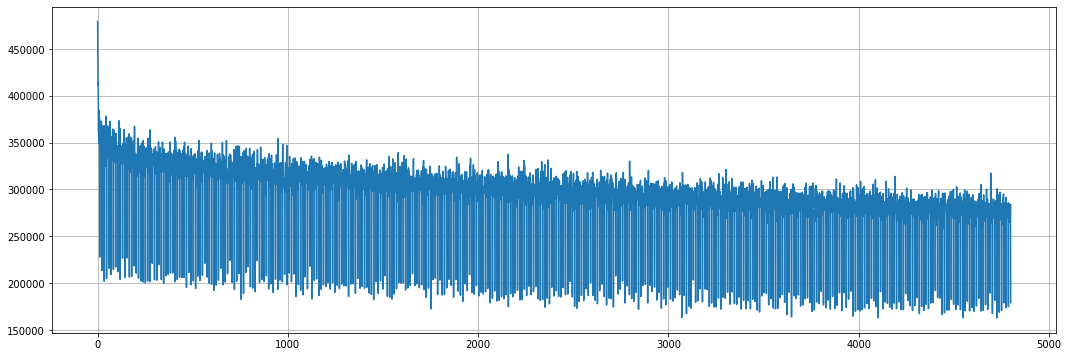

In [40]:
fig=plt.figure(figsize=(18, 6))
plt.plot(lossLst)
plt.grid()

#Test with training data

In [41]:
model.eval()
print("")

In [42]:
for batchX, _ in loader:
  break;
print(batchX.shape)

torch.Size([16, 3, 128, 128])


In [43]:
tensorY,mu,logvar = model(batchX.to(device))
print(tensorY.shape)

torch.Size([16, 3, 128, 128])


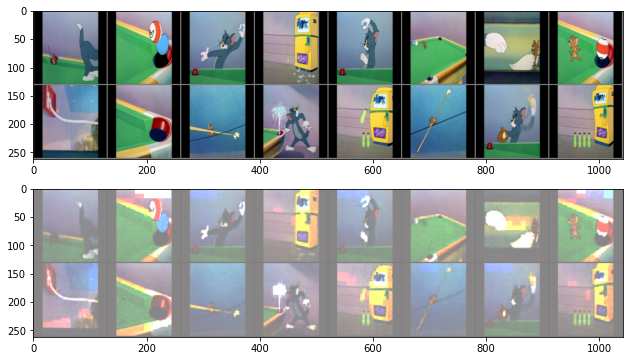

In [44]:
fig,axs=plt.subplots(2,1,figsize=(12,6))
imgArray=ConvertTensorToArray(batchX) 
axs[0].imshow(imgArray)
imgArray=ConvertTensorToArray(tensorY.cpu()) 
axs[1].imshow(imgArray)
plt.show()

#Test with un-seen test data

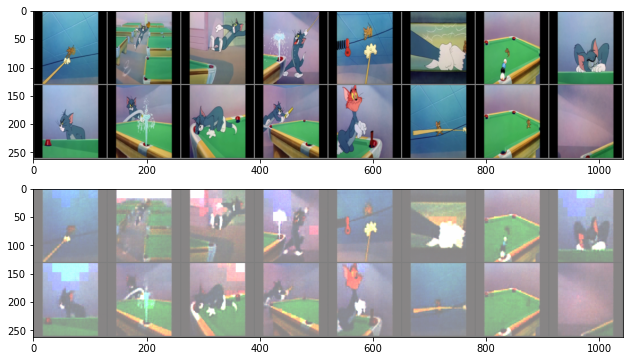

In [45]:
test_dataset = datasets.ImageFolder(root = "/content/gdrive/MyDrive/Image folders/test", transform = transformer)
loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=True)
for batchX, _ in loader:
  break;
tensorY,mu,logvar = model(batchX.to(device))

fig,axs=plt.subplots(2,1,figsize=(12,6))
imgArray=ConvertTensorToArray(batchX) 
axs[0].imshow(imgArray)
imgArray=ConvertTensorToArray(tensorY.cpu()) 
axs[1].imshow(imgArray)
plt.show()